## Assignment 2: Adversarial Training

This assignment requires you to create adversarial examples. You will do adversarial training, i.e., train the model with sets of adversarial examples you generated and evaluate the performances of the model on test sets.

### What is Adversarial Training?
Adversarial training is a machine learning technique to improve models' robustness by training them on adversarial examples. Adversarial examples are input data that has been intentionally modified to cause the model to misclassify or produce an incorrect output. 

When a model is trained using adversarial examples, it becomes more resilient to adversarial attacks and is able to better identify and classify input data that may have been modified or corrupted. This may lead to improved performance of the model in real-world scenarios where the input data may not always be perfect.

However, adversarial training can also have some negative impacts on ML models. For example, it can lead to overfitting, where the model becomes too specialized to the particular adversarial examples used in training and is unable to generalize well to new examples. Additionally, adversarial training can increase the computational requirements of training the model due to the need for generating adversarial examples.

Overall, while adversarial training can improve the robustness of ML models, it is important to carefully consider its potential benefits and drawbacks and to evaluate the trade-offs in terms of model performance and computational requirements. The following are the steps involved in adversarial training:

1. Generate adversarial examples: In the first step, we generate adversarial examples by perturbing the original data points in such a way that the modifications are small and not noticeable to humans but are enough to cause misclassification by the neural network.

2. Train on adversarial examples: In the second step, we train the neural network on adversarial examples in addition to the original training data. This helps to improve the network's ability to recognize and classify adversarial examples correctly.

3. Evaluate performance: In the third step, we evaluate the performance of the network on both the original and adversarial test data. This helps to determine if the adversarial training has improved the network's robustness against adversarial attacks.

Overall, adversarial training is a powerful technique that can help improve the security and reliability of deep neural networks.

In this Homework, you will run different adversarial training algorithms on the ResNet18 model with the adversarial examples, and evaluating the model performances on test data. The goal is to get experience in generating adversarial examples and train the model with these examples, i.e., adversarial training.

We have provided the model architecture ($\texttt{model.py}$) and some pre-defined functions ($\texttt{utils.py}$) so you can import and use them directly in the notebook.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from model import ResNet18
from utils import trades_loss, mixup_data, mixup_criterion, make_dataloader, eval_test

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

c:\Users\silvr\anaconda3\envs\Diffuser\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Using cuda device


### Q1 (20 points)
Use the following parameters to define the LinfPGDAttack():

- Epsilon: 8/255
- PGD Steps: 10
- PGD Step Size: 0.003

In [2]:
class LinfPGDAttack(nn.Module):
    def __init__(self, model, epsilon, steps=10, step_size=0.003):
        super().__init__()
        self.model = model
        self.epsilon = epsilon
        self.steps = steps
        self.step_size = step_size

    def perturb(self, x_natural, y):
        """
        Computes the gradient of the cross-entropy loss with respect to the input
        image `x_adv` and updates the image based on the gradient direction. The 
        perturbation is clipped to ensure it stays within a specified epsilon range
        and is finally clamped to ensure pixel values are valid. 
        
        The resulting perturbed image is returned.
        """
        # *********** Your code starts here ***********
        x_adv = x_natural.clone().detach().requires_grad_(True)
        for _ in range(self.steps):
            self.model.zero_grad()
            with torch.enable_grad():  
                pred_y = self.model(x_adv)
                loss = F.cross_entropy(pred_y, y)
            loss.backward()
            x_adv = x_adv + self.step_size * x_adv.grad.sign()
            x_adv = torch.min(torch.max(x_adv, x_natural - self.epsilon), x_natural + self.epsilon)
            x_adv = torch.clamp(x_adv, 0, 1)
        
            # Prepare x_adv for the next iteration
            x_adv = x_adv.detach().requires_grad_(True)

        # *********** Your code ends here *************
        return x_adv.detach()


    def forward(self, x_natural, y):
        x_adv = self.perturb(x_natural, y)
        return x_adv

There are many implementations of adversarial training; in this assignment, we ask you to evalaute which training algorithm can make the model more robust to LinfPGDAttack().

In [3]:
def train_ep(model, train_loader, mode, pgd_attack, optimizer, criterion, epoch, batch_size):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        if mode == 'natural':
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        elif mode == 'adv_train': # [Ref] https://arxiv.org/abs/1706.06083
            model.eval()
            adv_x = pgd_attack(inputs, targets)
            model.train()

            optimizer.zero_grad()
            outputs = model(adv_x)
            loss = criterion(outputs, targets)

        elif mode == 'adv_train_trades': # [Ref] https://arxiv.org/abs/1901.08573
            optimizer.zero_grad()
            loss = trades_loss(model=model, x_natural=inputs, y=targets, optimizer=optimizer)
            
        elif mode == 'adv_train_mixup': # [Ref] https://arxiv.org/abs/1710.09412
            model.eval()
            benign_inputs, benign_targets_a, benign_targets_b, benign_lam = mixup_data(inputs, targets)            
            adv_x = pgd_attack(inputs, targets)
            adv_inputs, adv_targets_a, adv_targets_b, adv_lam = mixup_data(adv_x, targets)
            
            model.train()
            optimizer.zero_grad()
            
            benign_outputs = model(benign_inputs)
            adv_outputs = model(adv_inputs)
            loss_1 = mixup_criterion(criterion, benign_outputs, benign_targets_a, benign_targets_b, benign_lam)
            loss_2 = mixup_criterion(criterion, adv_outputs, adv_targets_a, adv_targets_b, adv_lam)
            
            loss = (loss_1 + loss_2) / 2

        else:
            print("No training mode specified.")
            raise ValueError()

        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{:05d}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(inputs), len(train_loader) * batch_size,
                       100. * (batch_idx + 1) / len(train_loader), loss.item()))

In [4]:
def train(model, train_loader, val_loader, pgd_attack,
          mode='natural', epochs=25, batch_size=256, learning_rate=0.1, momentum=0.9, weight_decay=2e-4,
          checkpoint_path='model1.pt'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    best_acc = 0
    for epoch in range(epochs):
        # training
        train_ep(model, train_loader, mode, pgd_attack, optimizer, criterion, epoch, batch_size)

        # evaluate clean accuracy
        test_loss, test_acc = eval_test(model, val_loader)

        # remember best acc@1 and save checkpoint
        is_best = test_acc > best_acc
        best_acc = max(test_acc, best_acc)

        # save checkpoint if is a new best
        if is_best:
            torch.save(model.state_dict(), checkpoint_path)
        print('================================================================')

### Q2 (40 points)
Use the four training modes ("natural", "adv_train", "adv_train_trades", and "adv_train_mixup") to obtain four models, and save them as $\texttt{model1.pt}$, $\texttt{model2.pt}$, $\texttt{model3.pt}$, and $\texttt{model4.pt}$, respectively.

When calculating your losses, you may encounter Nan. In this case, you may consider adjusting the `learning rate` to solve the problem.

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# define parameters
batch_size = 256
data_path = './dataset/' # directory of the data
epsilon = 8/255
steps = 10
epochs = 100

# create data loader
train_loader, val_loader = make_dataloader(data_path, batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
training_mode = "natural"

# Define Model and Launch Training (Define Adversary If You Need It)
model = ResNet18()
model.to(device)
pgd_attack = LinfPGDAttack(model, epsilon, steps)

# Write your code here
train(model, train_loader, val_loader, pgd_attack,
          mode=training_mode, epochs=epochs, batch_size=batch_size, learning_rate=0.05, momentum=0.9, weight_decay=2e-4,
          checkpoint_path='model1.pt')

Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.379693
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 1.763642
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 1.549858
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 1.462425
Test: Average loss: 0.0056, Accuracy: 4868/10000 (49%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 1.462853
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 1.120599
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 1.099434
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 0.983411
Test: Average loss: 0.0076, Accuracy: 4631/10000 (46%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 0.993397
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 0.947940
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 0.903716
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 0.779034
Test: Average loss: 0.0036, Accuracy: 6821/10000 (68%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 0.630667
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 0.706712
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 0.609565
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 0.716051
Test: Average loss: 0.0

In [35]:
training_mode = "adv_train"

# Define Model and Launch Training (Define Adversary If You Need It)
model = ResNet18()
model.to(device)
pgd_attack = LinfPGDAttack(model, epsilon, steps)

# Write your code here
train(model, train_loader, val_loader, pgd_attack,
          mode=training_mode, epochs=epochs, batch_size=batch_size, learning_rate=0.05, momentum=0.9, weight_decay=2e-4,
          checkpoint_path='model2.pt')


Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.399941
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 2.133294
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 1.952570
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 1.958106
Test: Average loss: 0.0070, Accuracy: 3402/10000 (34%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 2.036206
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 1.892313
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 1.970586
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 1.892058
Test: Average loss: 0.0062, Accuracy: 4471/10000 (45%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 1.947528
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 1.889397
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 1.838431
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 1.854075
Test: Average loss: 0.0060, Accuracy: 4723/10000 (47%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 1.810272
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 1.894585
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 1.852957
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 1.910253
Test: Average loss: 0.0

In [14]:
training_mode = "adv_train_trades"

# Define Model and Launch Training (Define Adversary If You Need It)
model = ResNet18()
model.to(device)
pgd_attack = LinfPGDAttack(model, epsilon, steps)

# Write your code here
train(model, train_loader, val_loader, pgd_attack,
          mode=training_mode, epochs=epochs, batch_size=batch_size, learning_rate=0.05, momentum=0.9, weight_decay=2e-4,
          checkpoint_path='model3.pt')

c:\Users\silvr\anaconda3\envs\Diffuser\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.434535
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 1.860159
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 1.748769
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 1.636318
Test: Average loss: 0.0057, Accuracy: 4784/10000 (48%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 1.599250
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 1.547255
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 1.544613
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 1.423025
Test: Average loss: 0.0049, Accuracy: 5588/10000 (56%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 1.348335
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 1.377356
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 1.346141
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 1.245889
Test: Average loss: 0.0042, Accuracy: 6457/10000 (65%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 1.327585
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 1.222102
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 1.226705
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 1.207017
Test: Average loss: 0.0

In [38]:
training_mode = "adv_train_mixup"

# Define Model and Launch Training (Define Adversary If You Need It)
model = ResNet18()
model.to(device)
pgd_attack = LinfPGDAttack(model, epsilon, steps)

# Write your code here
train(model, train_loader, val_loader, pgd_attack,
          mode=training_mode, epochs=epochs, batch_size=batch_size, learning_rate=0.05, momentum=0.9, weight_decay=2e-4,
          checkpoint_path='model4.pt')

Train Epoch: 0 [00256/50176 (1%)]	 Loss: 2.372661
Train Epoch: 0 [13056/50176 (26%)]	 Loss: 2.079834
Train Epoch: 0 [25856/50176 (52%)]	 Loss: 2.076681
Train Epoch: 0 [38656/50176 (77%)]	 Loss: 2.042587
Test: Average loss: 0.0067, Accuracy: 4092/10000 (41%)
Train Epoch: 1 [00256/50176 (1%)]	 Loss: 1.924635
Train Epoch: 1 [13056/50176 (26%)]	 Loss: 1.973516
Train Epoch: 1 [25856/50176 (52%)]	 Loss: 1.968241
Train Epoch: 1 [38656/50176 (77%)]	 Loss: 1.976255
Test: Average loss: 0.0061, Accuracy: 4790/10000 (48%)
Train Epoch: 2 [00256/50176 (1%)]	 Loss: 2.013537
Train Epoch: 2 [13056/50176 (26%)]	 Loss: 2.047172
Train Epoch: 2 [25856/50176 (52%)]	 Loss: 1.876050
Train Epoch: 2 [38656/50176 (77%)]	 Loss: 2.026399
Test: Average loss: 0.0055, Accuracy: 5398/10000 (54%)
Train Epoch: 3 [00256/50176 (1%)]	 Loss: 1.995176
Train Epoch: 3 [13056/50176 (26%)]	 Loss: 1.952119
Train Epoch: 3 [25856/50176 (52%)]	 Loss: 2.028185
Train Epoch: 3 [38656/50176 (77%)]	 Loss: 1.628076
Test: Average loss: 0.0

### Q3 (20 points)
Use eval_robust() to evaluate each model's robustness against LinfPGDAttack().

In [31]:
from utils import eval_robust

# *********** Your code starts here ***********pgd_attack
model = ResNet18().to(device)
model.load_state_dict(torch.load('model1.pt', map_location=device))
pgd_attack = LinfPGDAttack(model, epsilon, steps)
robust_loss, robust_acc = eval_robust(model, val_loader, pgd_attack)
print(f'Training Mode: Natural, robust_loss: {robust_loss:.4f}, robust_acc: {robust_acc:.4f}%')
# *********** Your code ends here *************

LinfPGD Attack: Average loss: 0.1029, Robust Accuracy: 1/10000 (0%)
Training Mode: Natural, robust_loss: 0.1029, robust_acc: 0.0100%


In [37]:
# *********** Your code starts here ***********
model = ResNet18().to(device)
model.load_state_dict(torch.load('model2.pt', map_location=device))
pgd_attack = LinfPGDAttack(model, epsilon, steps)
robust_loss, robust_acc = eval_robust(model, val_loader, pgd_attack)
print(f'Training Mode: adv_train, robust_loss: {robust_loss:.4f}, robust_acc: {robust_acc:.4f}')
# *********** Your code ends here *************

LinfPGD Attack: Average loss: 0.0081, Robust Accuracy: 4611/10000 (46%)
Training Mode: adv_train, robust_loss: 0.0081, robust_acc: 46.1100


In [33]:
# *********** Your code starts here ***********
model = ResNet18().to(device)
model.load_state_dict(torch.load('model3.pt', map_location=device))
pgd_attack = LinfPGDAttack(model, epsilon, steps)
robust_loss, robust_acc = eval_robust(model, val_loader, pgd_attack)
print(f'Training Mode: adv_train_trades, robust_loss: {robust_loss:.4f}, robust_acc: {robust_acc:.4f}')
# *********** Your code ends here *************

LinfPGD Attack: Average loss: 0.0069, Robust Accuracy: 4384/10000 (44%)
Training Mode: adv_train_trades, robust_loss: 0.0069, robust_acc: 43.8400


In [39]:
# *********** Your code starts here ***********
model = ResNet18().to(device)
model.load_state_dict(torch.load('model4.pt', map_location=device))
pgd_attack = LinfPGDAttack(model, epsilon, steps)
robust_loss, robust_acc = eval_robust(model, val_loader, pgd_attack)
print(f'Training Mode: adv_train_mixup, robust_loss: {robust_loss:4f}, robust_acc: {robust_acc:4f}')
# *********** Your code ends here *************

LinfPGD Attack: Average loss: 0.0071, Robust Accuracy: 4054/10000 (41%)
Training Mode: adv_train_mixup, robust_loss: 0.007104, robust_acc: 40.540000


### Q4 (10 points)
Visualize 10 adversarial examples from (with ground truth labels and model's predictions) from the model having best robust accuarcy.

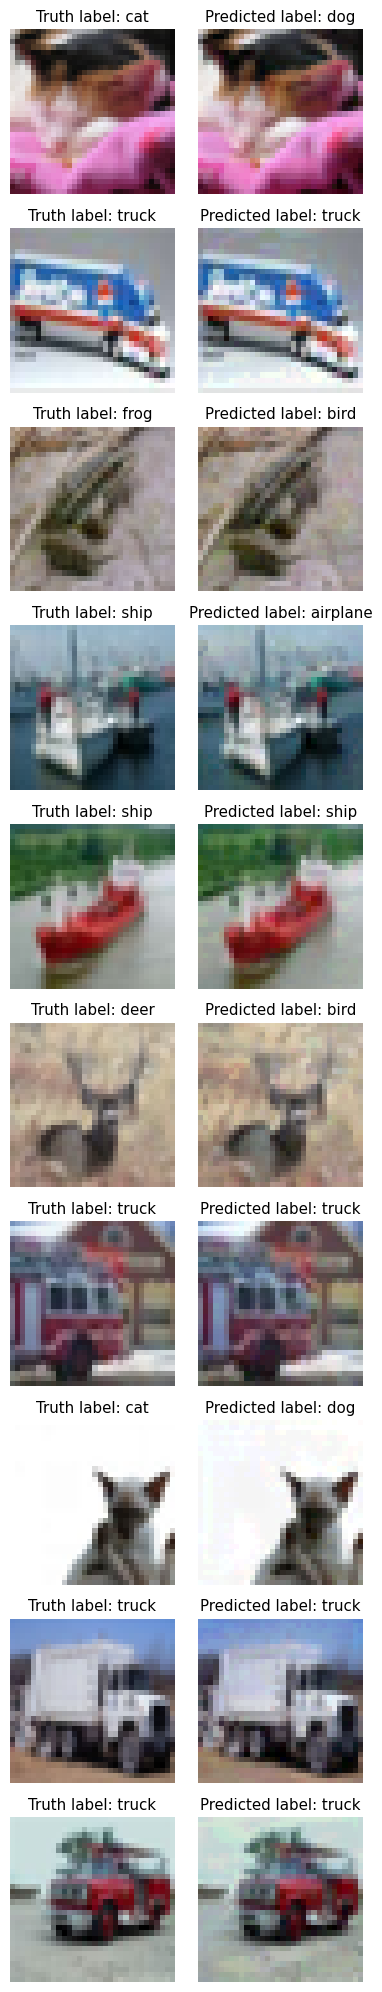

In [71]:
# *********** Your code starts here ***********

import matplotlib.pyplot as plt
label_map = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}   # Update this with actual mappings

def tensor_to_numpy(tensor):
    # Assuming tensor is in CxHxW format and normalized
    tensor = tensor.detach().cpu()
    tensor = torch.clamp(tensor, 0, 1)  # Clamp the values
    return tensor.numpy().transpose((1, 2, 0))

fig, axs = plt.subplots(10, 2, figsize=(4, 20))
plt.rc('font', size=9) 

for i in range(10):
    idx = random.randint(0, len(val_loader.dataset)-1)
    img, label = val_loader.dataset[idx]
    img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
    adv_img = pgd_attack(img, torch.tensor([label]).to(device))
    pred = model(adv_img).argmax(dim=1).item()
    original_img_np = tensor_to_numpy(img.squeeze(0))  # Remove batch dim for plotting
    adv_img_np = tensor_to_numpy(adv_img.squeeze(0))

    axs[i, 0].imshow(original_img_np)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Truth label: {label_map.get(label, "Unknown")}')    
    axs[i, 1].imshow(adv_img_np)
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Predicted label: {label_map.get(pred, "Unknown")}')

plt.tight_layout()
plt.show()
# *********** Your code ends here *************

### Q5 (10 points)
Which adversarial training algorithm achieves the best robust accuracy in only 25 training epochs? Why do you think that adversarial training algorithm outperforms others? Do you encounter any difficulties when you implement this assignment?

*Write your answer here.*

## Submission Instructions

Please submit this  to Canvas, as well as results, as per instructions. 
Please compress `First_Middle_Last_HW1/` into one zip file with the name `First_Middle_Last_HW1.zip` before uploading it to Canvas. The directory contains your notebook and four model checkpoints. As listed below:

- $\texttt{Assignment_2.ipynb}$: your code
- $\texttt{model1.pt}$: your model checkpoint with *natural training* 
- $\texttt{model2.pt}$: your model checkpoint with *adv_train* training
- $\texttt{model3.pt}$: your model checkpoint with *adv_train_trades* training
- $\texttt{model4.pt}$: your model checkpoint with *adv_train_mixup* training

## Academic Integrity

This homework assignment must be done individually. Sharing code or model specifications is strictly prohibited. Homework discussions are allowed only on Piazza, according to the policy outlined on the course web page: [https://canvas.dartmouth.edu/courses/63219](https://canvas.dartmouth.edu/courses/63219). You are not allowed to search online for auxiliary software, reference models, architecture specifications, or additional data to solve the homework assignment. Your submission must be entirely your own work. That is, the code and the answers that you submit must be created, typed, and documented by you alone, based exclusively on the materials discussed in class, and released with the homework assignment. You can obviously consult the class slides posted in Canvas, your lecture notes, and the textbook. Important: the models you will submit for this homework assignment must be
trained exclusively on the specified data provided with this assignment. You can, of course, play with other datasets in your spare time. These rules will be strictly enforced, and any violation will be treated seriously.